In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.copy_on_write = True

# Loading data

In [33]:
df = pd.read_csv('customer.csv')

# Exploratory Data Analysis and Preprocessing

Here we conduct a initial analysis of the dataset:

In [34]:
print("Seeing the first 10 lines of the dataset: \n")
print(df.head(10))
print('\n')
print("Counting the missing values in each column: \n")
print(df.isnull().sum())
print('\n')
print("Dataset info: \n")
print(df.info())
print("\n")
print("Number of rows:", len(df))
print("Number of columns:", len(df.columns))

Seeing the first 10 lines of the dataset: 

   Unnamed: 0        custid     sex is_employed   income      marital_status  \
0           7  000006646_03    Male        True  22000.0       Never married   
1           8  000007827_01  Female         NaN  23200.0  Divorced/Separated   
2           9  000008359_04  Female        True  21000.0       Never married   
3          10  000008529_01  Female         NaN  37770.0             Widowed   
4          11  000008744_02    Male        True  39000.0  Divorced/Separated   
5          15  000011466_01    Male         NaN  11100.0             Married   
6          17  000015018_01  Female        True  25800.0             Married   
7          19  000017314_02  Female         NaN  34600.0             Married   
8          20  000017383_04  Female        True  25000.0       Never married   
9          21  000017554_02    Male        True  31200.0             Married   

   health_ins                  housing_type  num_vehicles  age state_of_res

There are some null values in some columns that appear to be null for the same rows. In that case, dropping the rows could be a reasonable solution, if it doesn't cause a significant data loss.

In [35]:
n_null = len(df.loc[(df["housing_type"].isnull() == True) & (df["num_vehicles"].isnull() == True) 
                    & (df["gas_usage"].isnull() == True) & (df["recent_move_b"].isnull() == True)])
print(n_null)

1686


In [36]:
print(f"Percentage of data to be dropped: {(n_null / len(df)) * 100:.2f}%")

Percentage of data to be dropped: 2.33%


Since the rows are the same and it's just a 2% data loss, we decided to drop these rows.

In [37]:
df = df.dropna(subset=["housing_type"])

# checking if dropping worked
print(len(df[df["housing_type"].isnull() == True])) 
df[df["recent_move_b"].isnull() == True]

0


,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
10030,14009,001148287_01,Female,False,5000.0,Married,True,Homeowner with mortgage/loan,0.0,42,California,8962,3.0,4,NaN


There was still one missing value in the column recent_move_b so we replaced it with the mode:

In [38]:
mode = df["recent_move_b"].mode()[0]
df["recent_move_b"] = df["recent_move_b"].fillna(mode)
print(len(df[df["recent_move_b"].isnull() == True]))

0


Now we take a look at the unique values inside each column, to know which ones are categorical and which and how many categories are there.

In [39]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print(len(df[col].unique()))
    print("\n")

Unnamed: 0
[    7     8     9 ... 99997 99998 99999]
70772


custid
['000006646_03' '000007827_01' '000008359_04' ... '001507219_01'
 '001513103_01' '001519624_01']
70772


sex
['Male' 'Female']
2


is_employed
[True nan False]
3


income
[22000. 23200. 21000. ... 25110. 18010. 26850.]
4423


marital_status
['Never married' 'Divorced/Separated' 'Widowed' 'Married']
4


health_ins
[ True False]
2


housing_type
['Homeowner free and clear' 'Rented' 'Homeowner with mortgage/loan'
 'Occupied with no rent']
4


num_vehicles
[0. 2. 1. 5. 3. 4. 6.]
7


age
[ 24  82  31  93  67  76  26  73  27  54  61  64  55  65  33  47  68  46
  58  43  41  62  21  78  32  59  29  70  30  28  86  35  34  40  72  60
  25  79  22  42  44  81  50  45  63  57  39  71  38  49  69  37  66  53
  36  23  75  88  51  85  52  83  77  56  48 100  74  89  80  84   0  87
 120  91 110 114  94  90  96  92  95]
81


state_of_res
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Dist

We can see unnamed and custid columns have unique values, which won't be usefull for predictions. Also, we can see all numeric values are integers, and the one with more variability is income, which is expected.

Also we can see there are "nan" values on the is_employed column, which actually represent not in workforce, as said in the data dictionary. Thus, we have to be carefull to not treat the "nan" values as null values, but as a category.

Now, we can take a look on the age distribution to determine if the customers are mostly young, middle-aged or seniors.

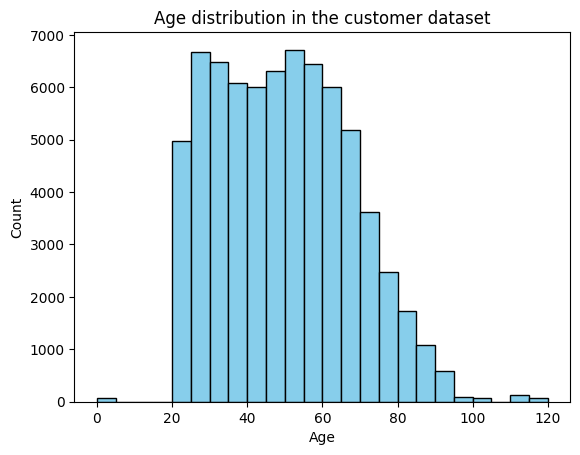

In [40]:
plt.hist(df["age"], bins=24, edgecolor='black', color='skyblue')
plt.title("Age distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Age")
plt.show()

The histogram shows there are mostly young adults and middle-aged customers. Each bin contains a 5 year interval. There are also potential errors/outliers (values near 120).

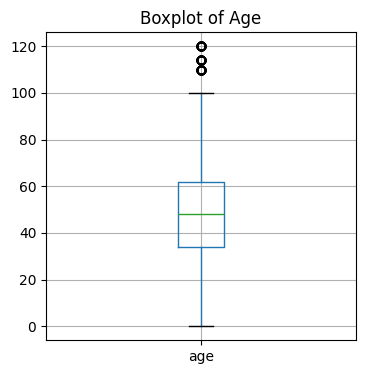

In [41]:
df.boxplot(column="age", figsize=(4,4))
plt.title('Boxplot of Age')
plt.show()

There are indeed some outliers that need to be addressed.

Now, we take a look at the income:

In [42]:
df["income"].describe()

count    7.077200e+04
mean     4.263163e+04
std      5.864181e+04
min     -6.900000e+03
25%      1.130000e+04
50%      2.748500e+04
75%      5.205500e+04
max      1.257000e+06
Name: income, dtype: float64

**Note**: Negative values represent loss.

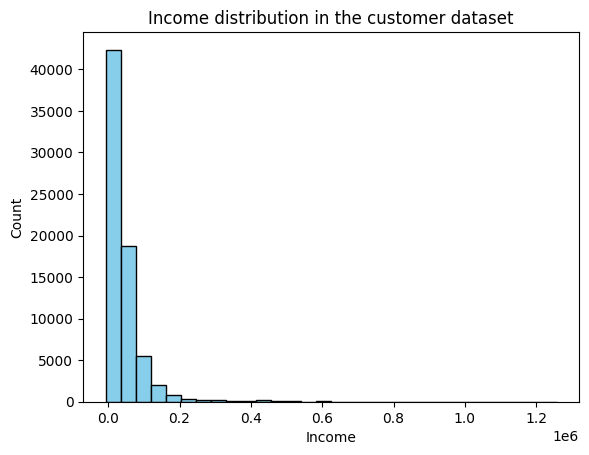

In [43]:
plt.hist(df["income"], edgecolor='black', color='skyblue', bins=30)
plt.title("Income distribution in the customer dataset")
plt.ylabel("Count")
plt.xlabel("Income")
plt.show()

It's highly right-skewed, which is expected for this variable. Now we can take a look at the boxplot:

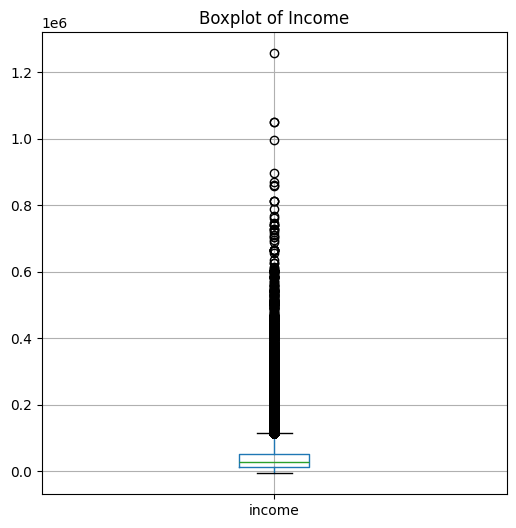

In [44]:
df.boxplot(column="income", figsize=(6,6))
plt.title('Boxplot of Income')
plt.show()

It shows a high number of outliers because of it's high concentration near the lower values (not a normal distribution).

In [45]:
print("Skewness:", df["income"].skew())
print("Kurtosis:", df["income"].kurtosis())

Skewness: 4.851249584109513
Kurtosis: 37.56168753204299


Left-skewness and very high kurtosis indicate transformations are needed before modeling.

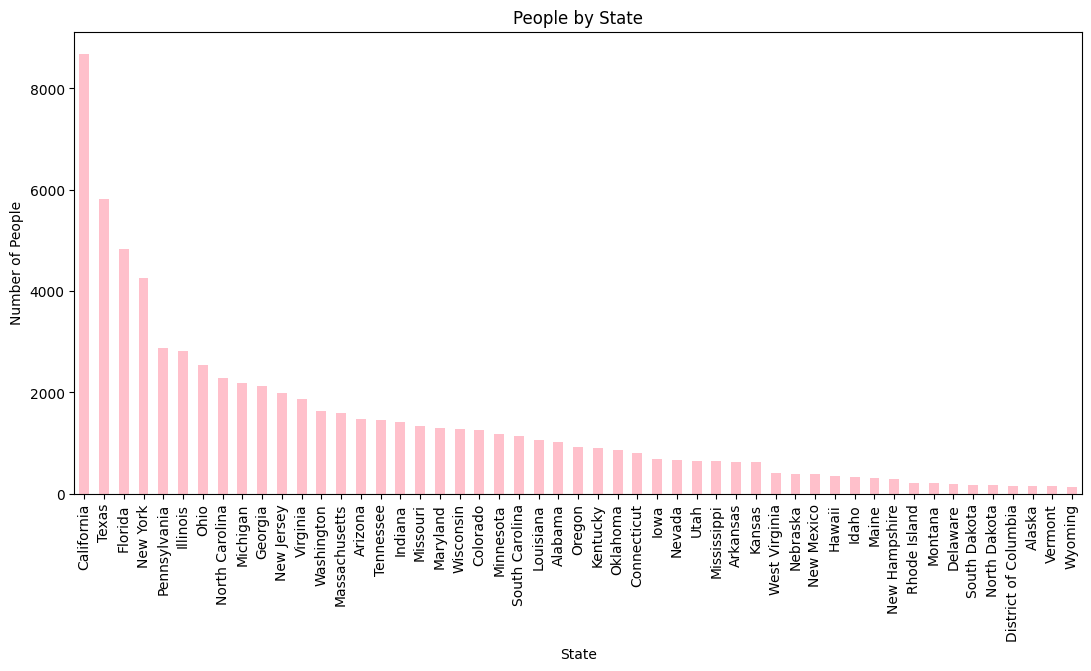

In [46]:
# Where do they live?

state_counts = df['state_of_res'].value_counts()
plt.figure(figsize=(13, 6))
state_counts.plot(kind='bar', color='pink')
plt.title('People by State')
plt.xlabel('State')
plt.ylabel('Number of People')
plt.show()

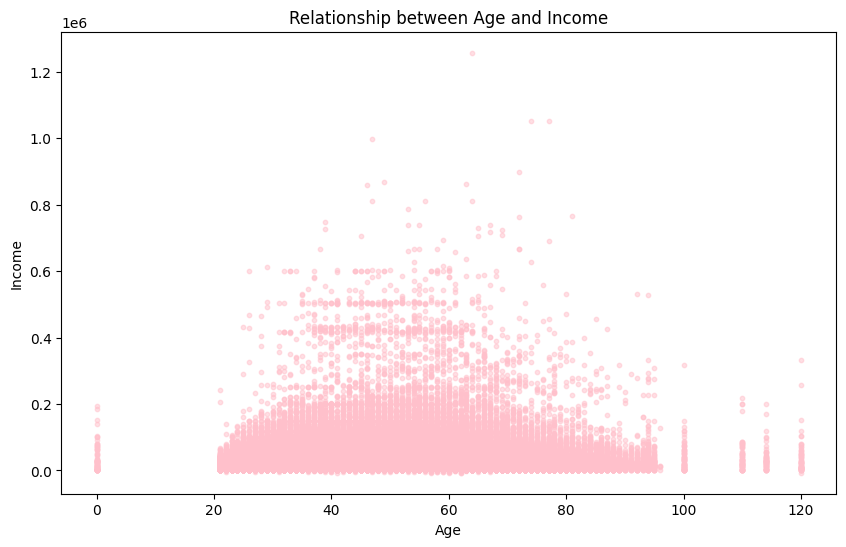

In [47]:
# What is the relation between age and income?

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['income'], alpha=0.5, s=10, color='pink')  
plt.title('Relationship between Age and Income')
plt.xlabel('Age')
plt.ylabel('Income')
plt.show()

(Como se pode ver no gráfico, há claros outliers na idade mas fora isso vemos que o income tem o seu peak na middle age (30-60) e mais baixos em pessoas mais velhas e mais novas que esse intervalo)

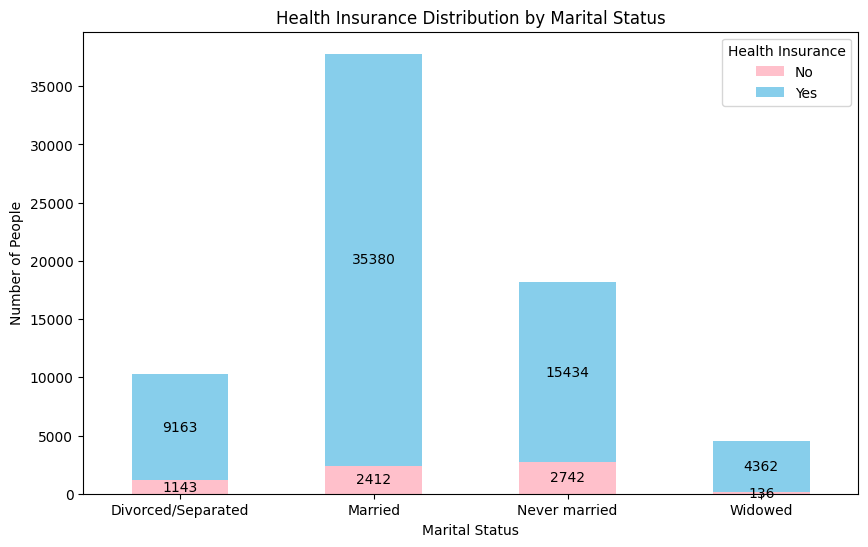

health_ins              False      True 
marital_status                          
Divorced/Separated  11.090627  88.909373
Married              6.382303  93.617697
Never married       15.085827  84.914173
Widowed              3.023566  96.976434


In [48]:
#How the health insurance distributes according to the marital status?

health_counts = df.groupby(['marital_status', 'health_ins']).size().unstack()
ax = health_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['pink', 'skyblue'])

# Add labels to each bar segment
for container in ax.containers:
    ax.bar_label(container, label_type='center')  

# Customize plot
plt.title('Health Insurance Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of People')
plt.legend(title='Health Insurance', labels=['No', 'Yes'])  
plt.xticks(rotation=0)  
plt.show()

# Percentages

print(health_counts.div(health_counts.sum(axis=1), axis=0) * 100)

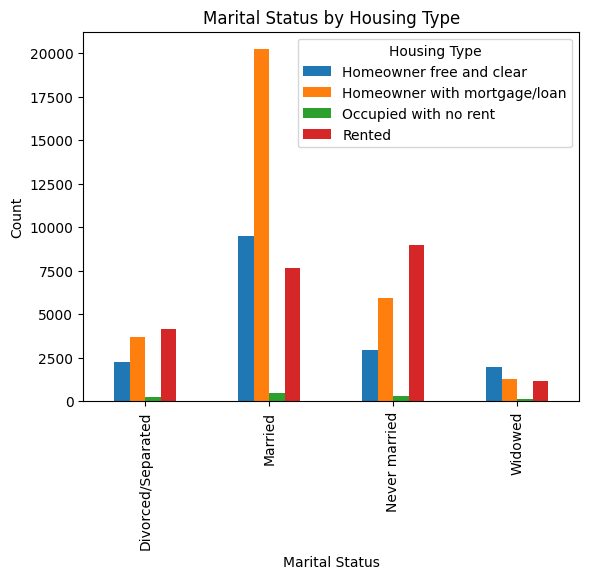

In [49]:
#Visualize the marital status according to the housing type 

marital_housing_counts = pd.crosstab(df['marital_status'], df['housing_type'])
marital_housing_counts.plot(kind='bar', stacked=False)
plt.title("Marital Status by Housing Type")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.legend(title="Housing Type")
plt.show()

             count          mean           std     min      25%      50%  \
age_group                                                                  
<25         6325.0  17870.236838  19152.237581 -5800.0   4300.0  13500.0   
25-34      13105.0  36652.213659  40669.306471 -5500.0  12000.0  29900.0   
35-49      18408.0  51488.357616  66424.568997 -6700.0  14200.0  35000.0   
50-64      18944.0  50419.020323  68862.305690 -6800.0  12000.0  32000.0   
65+        13727.0  37185.322066  54261.527828 -5500.0  11900.0  22000.0   

               75%        max  
age_group                      
<25        25000.0   433000.0  
25-34      50000.0   611000.0  
35-49      65000.0   997000.0  
50-64      62200.0  1257000.0  
65+        42300.0  1051000.0  
          count          mean           std     min      25%      50%  \
sex                                                                     
Female  36896.0  31658.612289  40588.002240 -6800.0   8600.0  20500.0   
Male    33876.0  54582.8

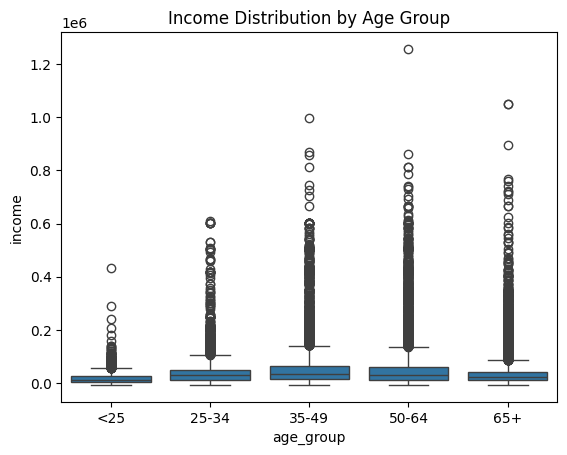

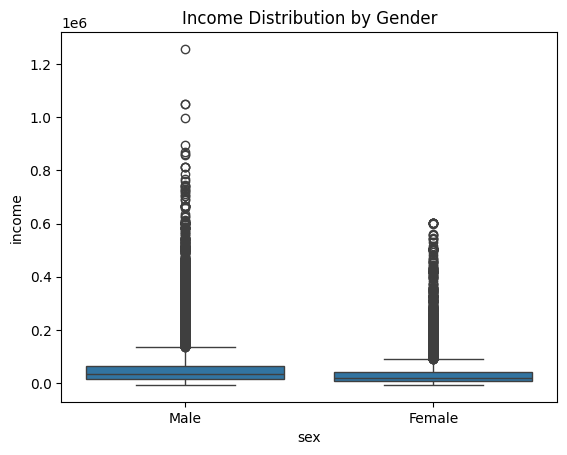

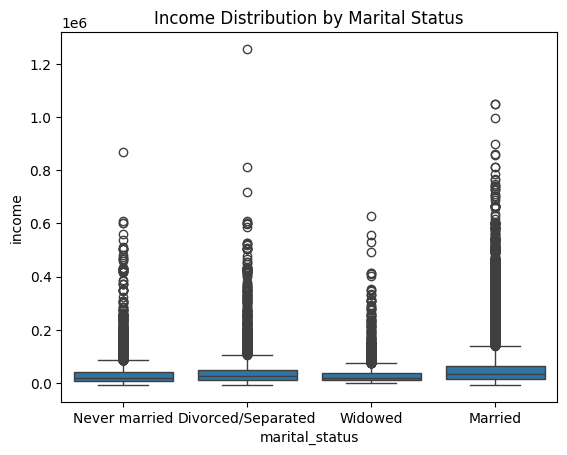

In [50]:
# Do you see differences in the income related to age, gender or the marital situation?

# Comparing incomes: 
# Income statistics by age
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 50, 65, 100], labels=['<25', '25-34', '35-49', '50-64', '65+'])
print(df.groupby('age_group', observed=True)['income'].describe())

# Income statistics by gender
print(df.groupby('sex')['income'].describe())

# Income statistics by marital status
print(df.groupby('marital_status')['income'].describe())

# Visualizing income differences:
# Income vs. Age
sns.boxplot(x='age_group', y='income', data=df)
plt.title("Income Distribution by Age Group")
plt.show()

# clean new column
df = df.drop(columns=["age_group"])

# Income vs. Gender
sns.boxplot(x='sex', y='income', data=df)
plt.title("Income Distribution by Gender")
plt.show()

# Income vs. Marital Status
sns.boxplot(x='marital_status', y='income', data=df)
plt.title("Income Distribution by Marital Status")
plt.show()

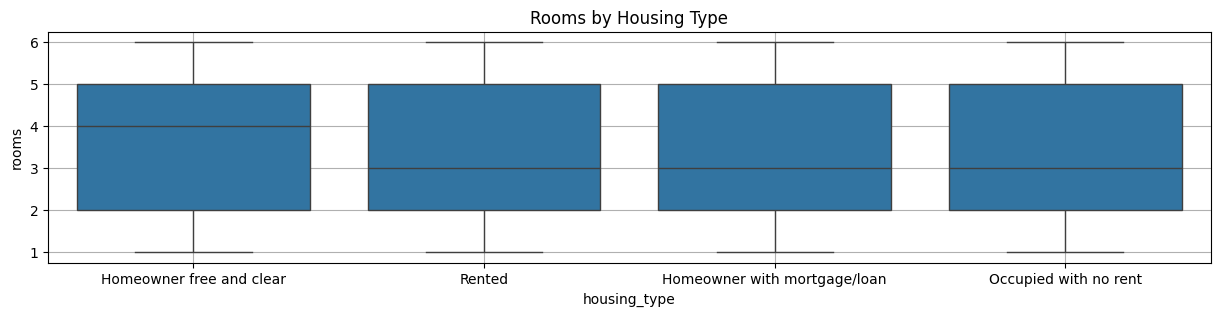

In [51]:
# Rooms by Housing Type
plt.figure(figsize=(15, 3))
sns.boxplot(x='housing_type', y='rooms', data=df)
plt.title("Rooms by Housing Type")
plt.grid()
plt.show()

Owned houses have more rooms (median is 4) than the others (median 3).

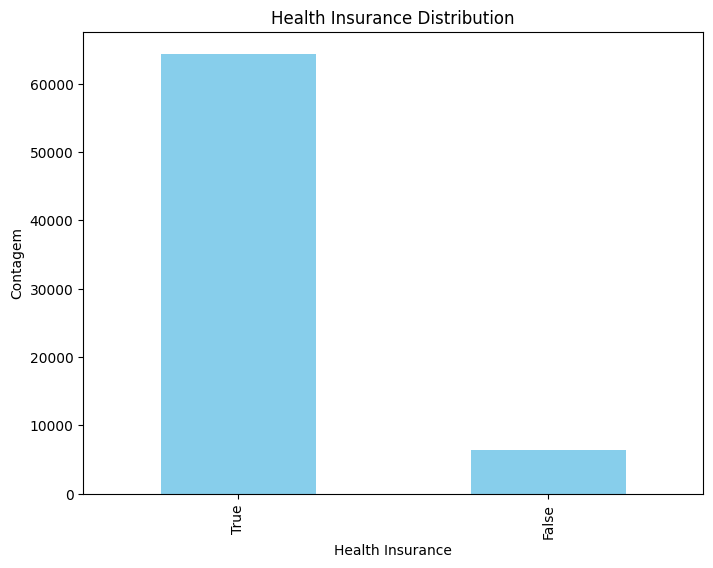

health_ins
True     64339
False     6433
Name: count, dtype: int64


In [52]:
health_ins_distribution = df['health_ins'].value_counts()

plt.figure(figsize=(8, 6))
health_ins_distribution.plot(kind='bar', color='skyblue')
plt.title('Health Insurance Distribution')
plt.xlabel('Health Insurance')
plt.ylabel('Contagem')
plt.show()

print(health_ins_distribution)

### Dropping and One-hot encoding

In [53]:
# Drop unnamed
df = df.drop(columns=['Unnamed: 0'])

# Drop custid and code_column
df = df.drop(columns=['custid', 'code_column'])
# code_column corresponds to state

df['is_employed'] = df['is_employed'].map({False: "unemployed", True: "employed"})
df['is_employed'] = df['is_employed'].fillna("not_in_workforce")

df['num_vehicles'] = df['num_vehicles'].astype(int)

df['gas_usage'] = df['gas_usage'].astype(int)
df['gas_usage'] = df['gas_usage'].replace([1, 2, 3], 0)

In [54]:
def encoding(df):
    df = pd.get_dummies(df, columns=['sex'], drop_first=True)

    df['recent_move_b'] = df['recent_move_b'].map({'F': 0, 'T': 1})

    # One-hot encoding
    df = pd.get_dummies(df, columns=['marital_status'], drop_first=True)
    df = pd.get_dummies(df, columns=['housing_type'], drop_first=True)
    df = pd.get_dummies(df, columns=['state_of_res'], drop_first=True)
    df = pd.get_dummies(df, columns=['is_employed'], drop_first=True)

    df = df.replace({True: 1, False: 0}).infer_objects(copy=False)
    
    return df
dfc= encoding(df)

C:\Users\claud\AppData\Local\Temp\ipykernel_15136\586721465.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0}).infer_objects(copy=False)


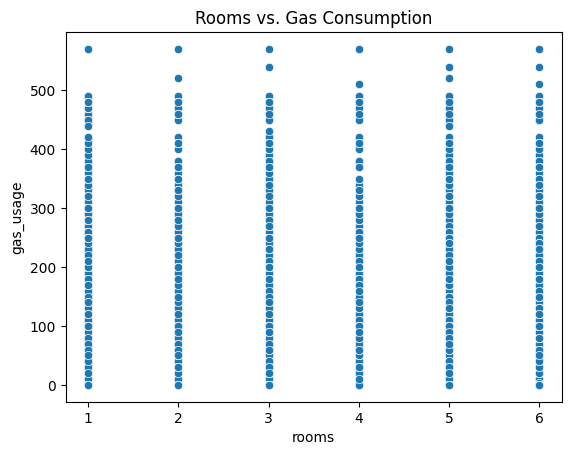

,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,gas_usage,rooms
housing_type_Homeowner with mortgage/loan,1.000000,-0.112249,-0.593655,0.116857,-0.003992
housing_type_Occupied with no rent,-0.112249,1.000000,-0.085043,-0.008072,-0.000834
housing_type_Rented,-0.593655,-0.085043,1.000000,-0.165388,0.000079
gas_usage,0.116857,-0.008072,-0.165388,1.000000,0.001158
rooms,-0.003992,-0.000834,0.000079,0.001158,1.000000


In [55]:
#Are the characteristics of the housing situation interrelated 
#(e.g. is the number of rooms related to the housing type or gas consumption?)

# Visualizing relationships:
sns.scatterplot(x='rooms', y='gas_usage', data=dfc)
plt.title("Rooms vs. Gas Consumption")
plt.show()

# Checking correlations:
housing_corr = dfc[['housing_type_Homeowner with mortgage/loan', 'housing_type_Occupied with no rent', 'housing_type_Rented', 'gas_usage', "rooms"]].corr()
housing_corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


Room is not correlated at all and gas_usage is just a bit with occupied with no rent and rented (less than 0.2).

Since gas_usage is also a numeric column, it's important to check if it is normally distributed or skewed before modeling.

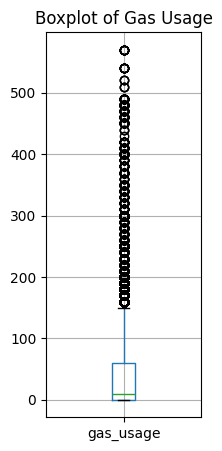

In [56]:
df.boxplot(column="gas_usage", figsize=(2,5))
plt.title('Boxplot of Gas Usage')
plt.show()

The boxplot shows it is skewed and needs handling.

### Data transformation

As it was seen, income and gas_usage are highly skewed and age has some unusual values that need to be handled. Therefore, we apply a logarithmic transformation to the first two and remove the outliers from the first one, since they're most likely wrong values.

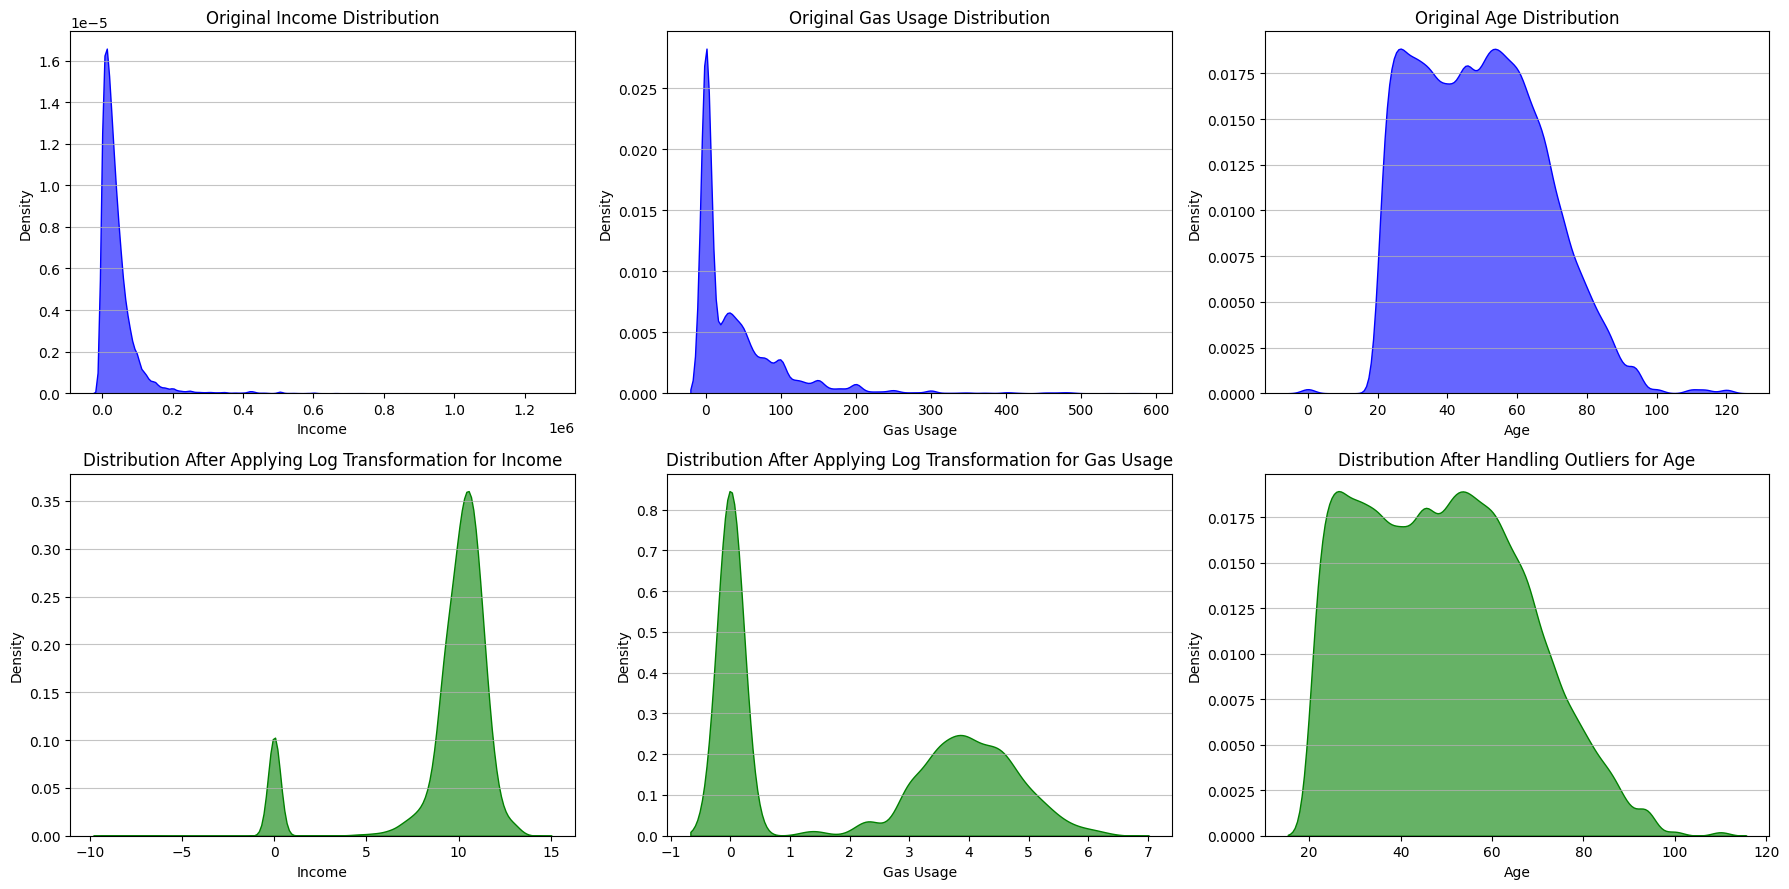

In [57]:
plt.figure(figsize=(18, 9))  

# Before (subplots 1, 2, 3)

plt.subplot(2, 3, 1)
sns.kdeplot(df['income'], fill=True, color='blue', alpha=0.6)
plt.title('Original Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 2)
sns.kdeplot(df['gas_usage'], fill=True, color='blue', alpha=0.6)
plt.title('Original Gas Usage Distribution')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 3)
sns.kdeplot(df['age'], fill=True, color='blue', alpha=0.6)
plt.title('Original Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

# Handling outliers for income, age, and gas usage
df['income'] = df['income'].apply(
    lambda x: np.log(x) if x > 0 else (-np.log(abs(x)) if x < 0 else 0)
)
#df['income'] = df['income'].where(df['income'] <= 0.1 * 10**6, 0.1 * 10**6)
df = df[(df['age'] != 0) & (df['age'] <= 110)]
df['gas_usage'] = df['gas_usage'].apply(lambda x: np.log(x) if x > 0 else 0)

# After handling outliers (subplots 4, 5, 6)

plt.subplot(2, 3, 4)
sns.kdeplot(df['income'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 5)
sns.kdeplot(df['gas_usage'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Applying Log Transformation for Gas Usage')
plt.xlabel('Gas Usage')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.subplot(2, 3, 6)
sns.kdeplot(df['age'], fill=True, color='green', alpha=0.6)
plt.title('Distribution After Handling Outliers for Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()  
plt.show()


After removing age outliers, would be interisting to visualize the probability of health insurance by age:

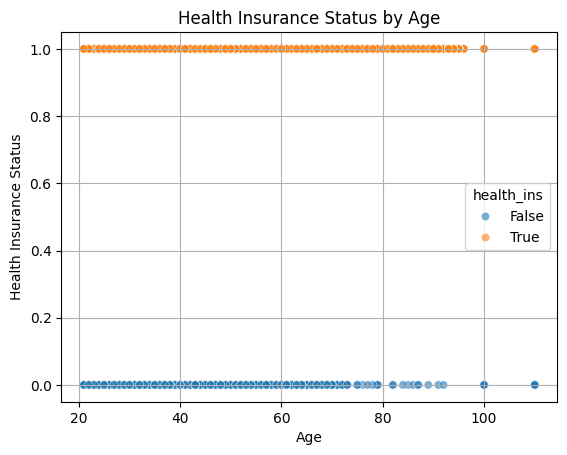

In [58]:
sns.scatterplot(x='age', y='health_ins', data=df, alpha=0.6, hue="health_ins")
plt.xlabel('Age')
plt.ylabel('Health Insurance Status')
plt.title('Health Insurance Status by Age')
plt.grid()
plt.show()

The graph shows there isn't a clear relationship for age and health insurance status, except for a small difference on the oldef ages where there seem to be more people with insurance than with not.

Now that we encoded all the categorical variables we can create the correlation matrix between all variables:

In [59]:
correlation_matrix = dfc.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,income,health_ins,num_vehicles,age,gas_usage,rooms,recent_move_b,sex_Male,marital_status_Married,marital_status_Never married,marital_status_Widowed,housing_type_Homeowner with mortgage/loan,housing_type_Occupied with no rent,housing_type_Rented,state_of_res_Alaska,state_of_res_Arizona,state_of_res_Arkansas,state_of_res_California,state_of_res_Colorado,state_of_res_Connecticut,state_of_res_Delaware,state_of_res_District of Columbia,state_of_res_Florida,state_of_res_Georgia,state_of_res_Hawaii,state_of_res_Idaho,state_of_res_Illinois,state_of_res_Indiana,state_of_res_Iowa,state_of_res_Kansas,state_of_res_Kentucky,state_of_res_Louisiana,state_of_res_Maine,state_of_res_Maryland,state_of_res_Massachusetts,state_of_res_Michigan,state_of_res_Minnesota,state_of_res_Mississippi,state_of_res_Missouri,state_of_res_Montana,state_of_res_Nebraska,state_of_res_Nevada,state_of_res_New Hampshire,state_of_res_New Jersey,state_of_res_New Mexico,state_of_res_New York,state_of_res_North Carolina,state_of_res_North Dakota,state_of_res_Ohio,state_of_res_Oklahoma,state_of_res_Oregon,state_of_res_Pennsylvania,state_of_res_Rhode Island,state_of_res_South Carolina,state_of_res_South Dakota,state_of_res_Tennessee,state_of_res_Texas,state_of_res_Utah,state_of_res_Vermont,state_of_res_Virginia,state_of_res_Washington,state_of_res_West Virginia,state_of_res_Wisconsin,state_of_res_Wyoming,is_employed_not_in_workforce,is_employed_unemployed
income,1.000000,0.121025,0.066445,0.048604,0.063112,-0.000566,-0.023678,0.195283,0.153870,-0.130962,-0.051650,0.157410,-0.035412,-0.136937,0.004322,-0.009000,-0.015381,0.024031,0.014363,0.028580,-0.003786,0.022105,-0.024861,-0.007898,0.001778,-0.002612,0.008802,-0.010800,-0.005078,-0.001539,-0.017120,-0.015081,-0.004487,0.019717,0.029615,-0.012054,0.008173,-0.015948,-0.007473,-0.002829,0.004015,-0.007238,0.008003,0.027103,-0.011867,0.023408,-0.012430,-0.001552,-0.011952,-0.017141,-0.009128,-0.003086,0.006459,-0.009359,-0.002721,-0.010532,-0.005747,-0.002756,0.002577,0.015571,0.010888,-0.014045,-0.002430,-0.002203,-0.266304,-0.085257
health_ins,0.121025,1.000000,0.036542,0.164322,0.043803,-0.005953,-0.058888,-0.047108,0.100821,-0.122619,0.054976,0.107773,-0.030010,-0.148150,-0.017492,-0.000163,0.003935,0.012813,0.006639,0.016400,0.003416,0.007877,-0.039627,-0.031283,0.016323,-0.002514,0.014638,0.000090,0.015525,0.001956,0.011254,-0.012338,0.002619,0.011543,0.032308,0.024998,0.022084,-0.011852,-0.001741,0.001965,-0.006729,-0.006243,0.004436,0.008267,-0.001756,0.021638,-0.022795,0.004939,0.019136,-0.016769,0.006311,0.024059,0.010367,-0.008658,-0.005712,-0.003029,-0.081876,0.002439,0.009850,0.001498,0.013418,0.011427,0.019417,-0.004136,0.047918,-0.100192
num_vehicles,0.066445,0.036542,1.000000,-0.127019,0.099663,-0.001894,-0.119345,0.058463,0.215738,-0.051290,-0.145558,0.281192,-0.040432,-0.315357,0.004983,-0.002131,0.003682,0.063139,0.017803,-0.004205,0.004397,-0.040495,-0.033701,0.004588,0.018349,0.011661,-0.016819,0.006628,0.009973,0.019028,0.000539,-0.010508,0.001820,0.000511,-0.024797,-0.004626,0.009687,0.000413,0.001433,0.017476,0.007250,-0.004903,0.009988,-0.012780,0.009148,-0.129034,0.011273,0.003554,-0.003011,-0.000410,0.011583,-0.015672,-0.005568,0.006008,0.009670,0.014959,0.017741,0.030200,-0.003914,0.020267,0.017611,-0.006402,0.007745,0.006755,-0.163509,-0.024232
age,0.048604,0.164322,-0.127019,1.000000,0.036756,-0.002090,-0.211363,-0.040864,0.151940,-0.456374,0.358433,-0.035045,0.003235,-0.249278,-0.012235,0.004873,-0.000506,-0.027932,-0.008320,0.013329,0.006322,-0.009732,0.035338,-0.009097,0.004586,0.003129,-0.003732,-0.003179,0.010561,0.001732,0.005384,-0.008466,0.013063,0.001951,0.005066,0.007091,0.002504,0.006218,-0.001152,0.007238,-0.000660,-0.003225,0.007654,0.003649,0.000935,0.002006,-0.003776,-0.001806,0.009328,-0.001872,0.005118,0.013345,0.001511,0.002067,0.005819,0.010543,-0.032315,-0.019779,0.006061,0.000619,-0.007253,0.010458,0.002524,-0.004223,0.460089,-0.096567
gas_usage,0.063112,0.043803,0.099663,

From that we conclude there is no variable with high enough correlation to make us drop it.

Looking at the health_ins column we can decide to drop some rows that show really low correlation, since they might not be very usefull for predicting the target variable.

**TO DO!!** 
drop one-hot encoding cols?

### Data scaling

In [60]:
from sklearn import preprocessing

def scaling(df):
    scaler = preprocessing.StandardScaler()

    # Identificar colunas binárias (valores únicos {0, 1})
    binary_cols = [col for col in df.columns if set(df[col].unique()) == {0, 1}]
    continuous_cols = [col for col in df.columns if col not in binary_cols]

    # Escalar apenas as colunas contínuas
    df_scaled = df.copy()
    df_scaled[continuous_cols] = scaler.fit_transform(df[continuous_cols])
    
    # Colunas binárias permanecem inalteradas
    return df_scaled

### Predict with K-NN

Balanced:

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

dfknn= scaling(dfc)

y = dfknn["health_ins"]
X = dfknn.drop(["health_ins"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)  # stratify makes it balanced?

num_neighbors = np.arange(1, 12)
train_accuracies = {}
test_accuracies = {}
f1_scores = {}

#for num in num_neighbors:
    # Set up a KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train)

# Compute accuracy
train_accuracies[0] = knn.score(X_train, y_train)
test_accuracies[0] = knn.score(X_test, y_test)

# Make predictions
y_pred = knn.predict(X_test)

# Compute F1-Score
f1_scores[0] = f1_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
precision = precision_score(y_test, y_pred, pos_label=0)

print(num_neighbors, '\n', train_accuracies, '\n', test_accuracies)
print(num_neighbors, '\n', f1_scores)
print(recall)
print(precision)

[ 1  2  3  4  5  6  7  8  9 10 11] 
 {0: 0.9189819312220711} 
 {0: 0.8954433062522077}
[ 1  2  3  4  5  6  7  8  9 10 11] 
 {0: 0.11904761904761904}
0.0777000777000777
0.2544529262086514


Non-balanced 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

num_neighbors = np.arange(1, 12)
train_accuracies = {}
test_accuracies = {}

for num in num_neighbors:
    # Set up a KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=num)
  
    # Fit the model
    knn.fit(X_train, y_train)
  
    # Compute accuracy
    train_accuracies[num] = knn.score(X_train, y_train)
    test_accuracies[num] = knn.score(X_test, y_test)

print(num_neighbors, '\n', train_accuracies, '\n', test_accuracies)
print(num_neighbors, '\n', f1_scores)

KeyboardInterrupt: 